
===== FUTURE SALES + PROFIT PREDICTION =====

📅 Prediction Result
Month : March 2025
💰 Predicted Sales  : 56663.76
📈 Predicted Profit : 9633.33
📊 Business Status  : ✅ PROFIT


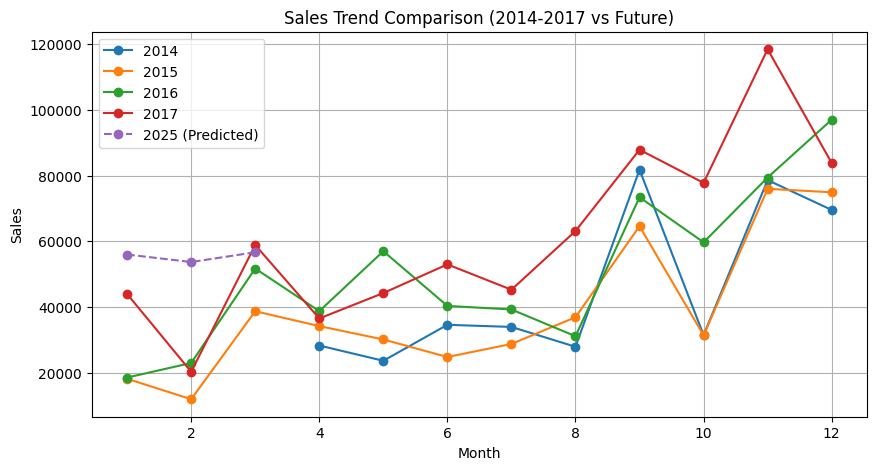

In [114]:
# ======================================
# 1️⃣ IMPORT LIBRARIES
# ======================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ======================================
# 2️⃣ LOAD DATASET
# ======================================
df = pd.read_csv(
    r"C:\Users\parth\OneDrive\Desktop\Task--1\Sample - Superstore.csv",
    encoding="latin1"
)

df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Order Date')

# ======================================
# 3️⃣ CREATE MONTHLY SALES + PROFIT SERIES
# ======================================
monthly = df.groupby(
    pd.Grouper(key='Order Date', freq='ME')
)[['Sales','Profit']].sum().reset_index()

# ======================================
# 4️⃣ FEATURE ENGINEERING
# ======================================
monthly['Month_Number'] = np.arange(len(monthly))
monthly['Month'] = monthly['Order Date'].dt.month
monthly['Year'] = monthly['Order Date'].dt.year
monthly['Quarter'] = monthly['Order Date'].dt.quarter

monthly['Lag1'] = monthly['Sales'].shift(1)
monthly['Lag2'] = monthly['Sales'].shift(2)
monthly['Lag3'] = monthly['Sales'].shift(3)
monthly['RollingMean3'] = monthly['Sales'].rolling(3).mean()

monthly.dropna(inplace=True)
monthly.reset_index(drop=True, inplace=True)

features = [
    'Month_Number','Month','Year','Quarter',
    'Lag1','Lag2','Lag3','RollingMean3'
]

X = monthly[features]

# ======================================
# 5️⃣ TRAIN TWO MODELS (SALES + PROFIT)
# ======================================
sales_model = RandomForestRegressor(n_estimators=400,max_depth=10,random_state=42)
profit_model = RandomForestRegressor(n_estimators=400,max_depth=10,random_state=42)

sales_model.fit(X, monthly['Sales'])
profit_model.fit(X, monthly['Profit'])

# ======================================
# ⭐ FUNCTION → PREDICT + CONFIDENCE
# ======================================
def predict_with_confidence(model, X_row):
    tree_preds = np.array([tree.predict(X_row.values)[0] for tree in model.estimators_])
    mean_pred = tree_preds.mean()
    std_pred = tree_preds.std()
    confidence = max(0, 100 - (std_pred / abs(mean_pred))*100) if mean_pred!=0 else 0
    return mean_pred, std_pred, confidence

# ======================================
# 6️⃣ USER INPUT
# ======================================
print("\n===== FUTURE SALES + PROFIT PREDICTION =====")
date_input = input("Enter future date (YYYY-MM or YYYY-MM-DD): ")

future_date = pd.to_datetime(date_input)
last_date = monthly['Order Date'].max()

months_to_predict = (
    (future_date.year - last_date.year) * 12 +
    (future_date.month - last_date.month)
)

if months_to_predict <= 0:
    print("❌ Enter FUTURE date.")
    exit()

# ======================================
# 7️⃣ ITERATIVE FORECAST
# ======================================
last_row = monthly.tail(1).copy()
future_rows = []

for _ in range(months_to_predict):

    new_row = last_row.copy()

    new_row['Month_Number'] += 1
    new_row['Order Date'] += pd.DateOffset(months=1)

    new_row['Month'] = new_row['Order Date'].dt.month
    new_row['Year'] = new_row['Order Date'].dt.year
    new_row['Quarter'] = new_row['Order Date'].dt.quarter

    new_row['Lag3'] = new_row['Lag2']
    new_row['Lag2'] = new_row['Lag1']
    new_row['Lag1'] = new_row['Sales']

    new_row['RollingMean3'] = new_row[['Lag1','Lag2','Lag3']].mean(axis=1)

    X_future = new_row[features]

    # SALES prediction
    sales_pred, std_s, conf_s = predict_with_confidence(sales_model, X_future)

    # PROFIT prediction
    profit_pred, std_p, conf_p = predict_with_confidence(profit_model, X_future)

    new_row['Sales'] = sales_pred
    new_row['Profit'] = profit_pred

    future_rows.append(new_row.iloc[0])
    last_row = new_row

future_df = pd.DataFrame(future_rows)

# ======================================
# 8️⃣ OUTPUT RESULT
# ======================================
status = "✅ PROFIT" if profit_pred >= 0 else "❌ LOSS"

print("\n📅 Prediction Result")
print(f"Month : {future_date.strftime('%B %Y')}")
print(f"💰 Predicted Sales  : {sales_pred:.2f}")
print(f"📈 Predicted Profit : {profit_pred:.2f}")
print(f"📊 Business Status  : {status}")

# ======================================
# 9️⃣ LINE GRAPH COMPARISON (2014–2017 + FUTURE)
# ======================================
plt.figure(figsize=(10,5))

for year in [2014,2015,2016,2017]:
    year_data = monthly[monthly['Year']==year]
    plt.plot(year_data['Month'],year_data['Sales'],marker='o',label=str(year))

# Future year
future_year = future_date.year
future_year_data = future_df[future_df['Year']==future_year]

if not future_year_data.empty:
    plt.plot(future_year_data['Month'],future_year_data['Sales'],
             marker='o',linestyle='--',label=f"{future_year} (Predicted)")

plt.title("Sales Trend Comparison (2014-2017 vs Future)")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()
